## Loading a Pretrained Model

This section demonstrates how to load the previously trained mango leaf disease classification model for reuse, evaluation, or further training.

### Components

- **Imports**
  - `load_model`: Loads a saved Keras model from an `.h5` file.  
  - `tensorflow as tf`: Core deep learning framework.  
  - `preprocess_input`: Ensures new input images are preprocessed correctly for MobileNetV2.  
  - `Adam`: Optimizer, in case fine-tuning or retraining is required.  
  - `EarlyStopping`, `ModelCheckpoint`: Callbacks that can be reused when resuming training.  
  - `os`: For managing file paths and directory operations.  

- **Load Model**
  - `model = load_model("mango_leaf_disease_mobilenetv2.h5")`  
  - Restores the previously trained MobileNetV2-based model from disk.  
  - The loaded model is ready for:  
    - Making predictions on new images.  
    - Further fine-tuning with additional training data.  
    - Re-exporting in TensorFlow Lite format for deployment.  

### Purpose
Loading a saved model avoids retraining from scratch, enabling faster experimentation, transfer to new datasets, or deployment in real-world applications.  


In [ ]:
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

# Load previously trained mango model
model = load_model("mango_leaf_disease_mobilenetv2.h5")

## Dataset Loading

This section defines dataset paths, sets input parameters, and loads the training, validation, and testing datasets into TensorFlow.

### Components

- **Paths**
  - `data_dir`: Root directory containing the dataset.  
  - `train_dir`, `val_dir`, `test_dir`: Subdirectories for training, validation, and testing images.  
  - Each of these directories is expected to contain **class-specific subfolders** (e.g., `Healthy`, `Anthracnose`, `OtherDisease`).  

- **Parameters**
  - `img_size = (224, 224)`: Images are resized to MobileNetV2’s required input shape.  
  - `batch_size = 32`: Defines how many images are processed together per training step.  

- **Dataset Loading**
  - `tf.keras.utils.image_dataset_from_directory`:  
    - Automatically reads images from the specified directory.  
    - Infers class labels from folder names.  
    - Resizes and batches the data.  
  - Creates three datasets:  
    - `train_ds`: Used to train the model.  
    - `val_ds`: Used for hyperparameter tuning and validation during training.  
    - `test_ds`: Used for final performance evaluation after training.  

### Purpose
This setup ensures that image data is efficiently loaded, labeled, resized, and batched, making it ready for preprocessing and model training.  


In [3]:
data_dir = r"C:\Users\Jaero\Desktop\Programming\DP1\Plant_Disease_Prediction\data"
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "valid")
test_dir = os.path.join(data_dir, "test")

# Parameters
img_size = (224, 224)   # MobileNetV2 input size
batch_size = 32

# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=img_size,
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=img_size,
    batch_size=batch_size
)


Found 2100 files belonging to 3 classes.
Found 600 files belonging to 3 classes.
Found 299 files belonging to 3 classes.


In [12]:
class_names = ['Anthracnose', 'Healthy', 'OtherDisease']

## Data Preprocessing

This step prepares the dataset so that it matches the expected input format for **MobileNetV2**.

### Components

- **Function: `preprocess(images, labels)`**
  - Applies `preprocess_input(images)` from `tensorflow.keras.applications.mobilenet_v2`.  
  - This function performs MobileNetV2-specific preprocessing:
    - Converts image pixels from `[0, 255]` range to `[-1, 1]`.  
    - Normalizes input in the way the pre-trained ImageNet weights expect.  
  - Returns the transformed images along with their original labels.

- **Mapping to Datasets**
  - `train_ds = train_ds.map(preprocess)`  
  - `val_ds = val_ds.map(preprocess)`  
  - `test_ds = test_ds.map(preprocess)`  
  - Each dataset (`train`, `val`, `test`) is passed through the `preprocess` function.  

### Purpose
- Ensures **consistency** between training, validation, and test sets.  
- Matches MobileNetV2’s input requirements for transfer learning.  
- Prevents data mismatch errors during model training and evaluation.  


In [4]:
def preprocess(images, labels):
    images = preprocess_input(images)  # Important for MobileNetV2
    return images, labels

train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)
test_ds = test_ds.map(preprocess)

## Freezing Layers in Transfer Learning  

This section configures which layers of the pre-trained model should remain frozen and which should be trainable during fine-tuning.  

### Key Operation  

- **for layer in model.layers[:-20]: layer.trainable = False**  
  - Iterates through all layers of the model except the last 20.  
  - Sets `trainable = False`, meaning those layers’ weights will not be updated during training.  


In [5]:
for layer in model.layers[:-20]:
    layer.trainable = False

## Model Compilation  

This step configures the model for training by specifying the optimizer, loss function, and evaluation metrics.  

### Components  

- **Optimizer: `Adam(learning_rate=1e-5)`**  
  - An adaptive learning rate optimizer that combines the benefits of AdaGrad and RMSProp.  
  - A small learning rate (`1e-5`) is chosen to ensure gradual fine-tuning without overwriting pre-trained weights.  

- **Loss Function: `sparse_categorical_crossentropy`**  
  - Suitable for **multi-class classification** problems.  
  - Works with integer class labels instead of requiring one-hot encoding.  
  - Penalizes incorrect predictions by comparing predicted probabilities with true class labels.  

- **Metrics: `accuracy`**  
  - Tracks the percentage of correct predictions during both training and validation.  
  - Provides an intuitive way to evaluate model performance across epochs.  

### Purpose  

- Prepares the model for **fine-tuning** on the mango leaf disease dataset.  
- Ensures the training process updates only the selected trainable layers with small, controlled adjustments.  
- Provides a balance between **preserving pre-trained knowledge** and **adapting to the new classification task**.  


In [6]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # small LR for fine-tuning
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

## Training Callbacks  

This step defines callback functions to improve the training process by controlling overfitting and saving the best version of the model.  

### Components  

- **EarlyStopping**  
  - **Function:** `EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)`  
  - Monitors validation loss during training.  
  - Stops training if validation loss does not improve for **3 consecutive epochs**.  
  - Restores the model weights from the **best-performing epoch**, preventing overfitting in later epochs.  

- **ModelCheckpoint**  
  - **Function:** `ModelCheckpoint("fine_tuned_model.h5", monitor="val_loss", save_best_only=True, mode="min")`  
  - Saves the model whenever validation loss improves.  
  - **`save_best_only=True`** ensures only the best-performing model is kept.  
  - **`mode="min"`** ensures the checkpoint saves the model only when a new minimum validation loss is reached.  
  - The best model is stored as **`fine_tuned_model.h5`** for later use.  

### Purpose  

- **EarlyStopping** prevents overfitting and unnecessary training by halting when no progress is observed.  
- **ModelCheckpoint** guarantees that the **best version of the model** is saved during training.  
- Combined, these callbacks make training more **efficient, reliable, and reproducible**.  


In [7]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "fine_tuned_model.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min"
)

## Model Training  

This step trains the fine-tuned **MobileNetV2** model on the prepared dataset while using callbacks to optimize the process.  

### Components  

- **Function: `model.fit()`**  
  - **Parameters:**  
    - `train_ds` → Training dataset used to update model weights.  
    - `validation_data=val_ds` → Validation dataset to monitor performance and prevent overfitting.  
    - `epochs=50` → Maximum number of training iterations (may stop earlier due to EarlyStopping).  
    - `callbacks=[early_stopping, checkpoint]` → Uses predefined callbacks to control training.  

- **Callbacks in Action:**  
  - **EarlyStopping** halts training early if validation loss does not improve.  
  - **ModelCheckpoint** ensures the best model (lowest validation loss) is saved.  

- **Output:**  
  - The function returns a **`history` object** that stores training and validation metrics (loss, accuracy) per epoch for later analysis and visualization.  

### Purpose  

- Ensures that the model **learns effectively** from training data while being **evaluated on validation data** each epoch.  
- Prevents unnecessary training when improvements stop (via EarlyStopping).  
- Saves the **best-perfo**


In [8]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/50
66/66 [==============================] - 16s 95ms/step - loss: 1.0368 - accuracy: 0.6190 - val_loss: 0.8998 - val_accuracy: 0.6567
Epoch 2/50
66/66 [==============================] - 6s 79ms/step - loss: 0.9489 - accuracy: 0.6571 - val_loss: 0.7992 - val_accuracy: 0.6783
Epoch 3/50
66/66 [==============================] - 5s 76ms/step - loss: 0.8493 - accuracy: 0.6819 - val_loss: 0.7330 - val_accuracy: 0.7000
Epoch 4/50
66/66 [==============================] - 5s 74ms/step - loss: 0.7718 - accuracy: 0.6910 - val_loss: 0.6909 - val_accuracy: 0.7050
Epoch 5/50
66/66 [==============================] - 5s 75ms/step - loss: 0.7692 - accuracy: 0.7024 - val_loss: 0.6589 - val_accuracy: 0.7100
Epoch 6/50
66/66 [==============================] - 6s 79ms/step - loss: 0.7257 - accuracy: 0.7105 - val_loss: 0.6333 - val_accuracy: 0.7150
Epoch 7/50
66/66 [==============================] - 5s 76ms/step - loss: 0.7009 - accuracy: 0.7181 - val_loss: 0.6118 - val_accuracy: 0.7233
Epoch 8/50
6

## Model Predictions and Classification Report

This section generates predictions on the test dataset and evaluates the model’s performance using detailed classification metrics.

### Components

- **Prediction Loop**
  - Iterates over the batches in `test_ds`.  
  - `model.predict(images)`: Produces probability distributions for each class.  
  - `np.argmax(preds, axis=1)`: Converts probabilities into class predictions.  
  - Predictions (`y_pred_classes`) and true labels (`y_true`) are collected and stored as NumPy arrays for evaluation.  

- **Evaluation Metrics**
  - `classification_report(y_true, y_pred_classes, target_names=class_names)`  
    - Provides precision, recall, F1-score, and support (number of samples) for each class.  
    - Useful for analyzing per-class performance, not just overall accuracy.  

- **Confusion Matrix**
  - `confusion_matrix(y_true, y_pred_classes)` (defined earlier) complements the classification report by showing class-level misclassifications.  

### Purpose
Together, these metrics provide a comprehensive evaluation of the trained model:  
- **Classification Report** → Summarizes quantitative performance across all classes.  
- **Confusion Matrix** → Visualizes where the model is making correct or incorrect predictions.  


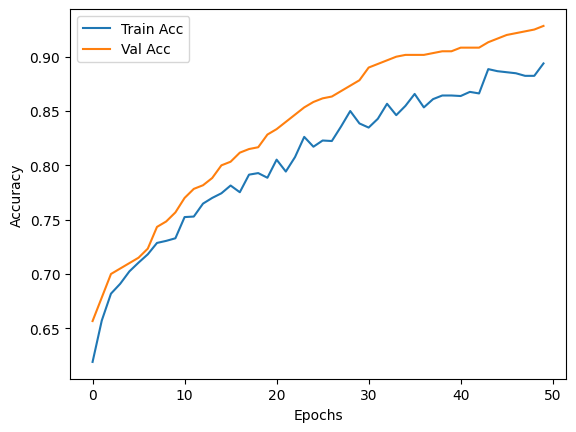

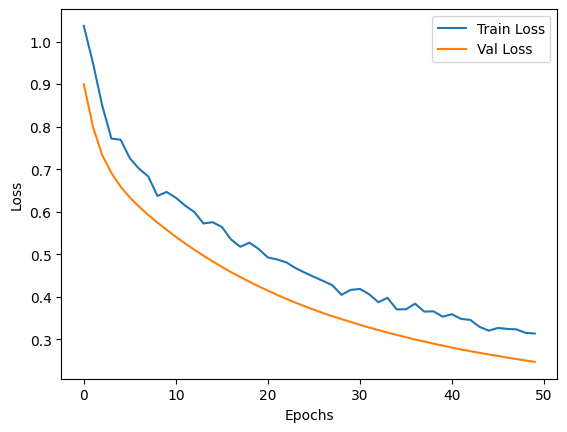

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Accuracy
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
y_true = []
y_pred_classes = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_pred_classes.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred_classes = np.array(y_pred_classes)

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred_classes, target_names=class_names))

1/1 [==============================] - 0s 30ms/step
              precision    recall  f1-score   support

 Anthracnose       0.96      0.97      0.97       100
     Healthy       0.88      0.96      0.92       100
OtherDisease       0.93      0.84      0.88        99

    accuracy                           0.92       299
   macro avg       0.92      0.92      0.92       299
weighted avg       0.92      0.92      0.92       299



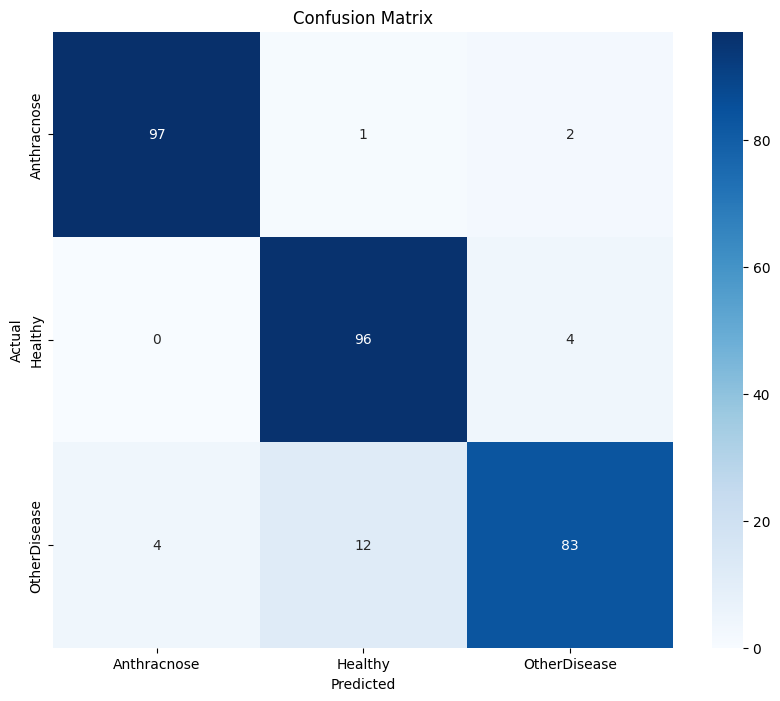

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# y_true and y_pred_classes are already correct
# class_names is your list of class labels

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [15]:
for images, labels in test_ds.take(1):
    preds = np.argmax(model.predict(images), axis=1)
    print("Predicted:", preds)
    print("Actual   :", labels.numpy())

1/1 [==============================] - 0s 49ms/step
Predicted: [0 0 0 0 1 0 1 0 1 1 2 1 1 2 2 1 2 2 1 1 1 2 0 0 2 1 1 0 0 1 2 1]
Actual   : [0 0 0 0 1 0 1 2 1 2 2 1 1 2 2 1 1 2 1 1 1 2 0 0 2 1 1 0 0 2 2 1]


In [16]:
model.save('ft1_mango_leaf_disease.h5')

## Model Saving and Export

This section demonstrates how to save the trained model for later use and optionally convert it to a lightweight format for deployment.

### Components

- **Saving the Keras Model**
  - `model.save("mango_leaf_disease_mobilenetv2.h5")`  
  - Saves the trained model in HDF5 (`.h5`) format.  
  - The saved model includes architecture, weights, and optimizer state, allowing it to be reloaded and used without retraining.  

- **TensorFlow Lite Conversion**
  - `tf.lite.TFLiteConverter.from_keras_model(model)` creates a converter to transform the model into TensorFlow Lite format.  
  - `converter.convert()` generates a `.tflite` version of the model.  
  - The converted model can be saved as a file (e.g., `mango_mobilenetv2.tflite`) and deployed to **mobile devices or edge hardware** such as Raspberry Pi, microcontrollers, or Android apps.  

### Purpose
- `.h5` model → for reuse in Python/TensorFlow environments.  
- `.tflite` model → for deployment in **resource-constrained devices**, enabling real-time inference on mobile or embedded systems.  


In [13]:

model = load_model("../h5/ft1_mango_leaf_disease.h5")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("ft1_mango_mobilenetv2.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Jaero\AppData\Local\Temp\tmp2lz_h1ap\assets


INFO:tensorflow:Assets written to: C:\Users\Jaero\AppData\Local\Temp\tmp2lz_h1ap\assets
